# Wind retrievel for RPG radar

**lidarwind** is the package name used to retrieve wind profiles from the radar PPI scans. The package was initially developed to process wind lidar data (https://doi.org/10.21105/joss.04852). Because the physical principle of retrieving wind from lidar and radar observations is the same, lidar wind was extended to support the RPG radar data. Below, you will find an example of lidarwind applied to RPG PPI radar data.

You can find more information about lidarwind at: https://lidarwind.readthedocs.io/

## Steps:

 1. Dependence installation
 2. Importing the required packages
 3. Defining useful functions
 4. Getting sample data
 5. Retrieving wind
 6. Visualising the results

## Step 1: Dependence installation

The cell below installs an additional package required by lidarwind.

In [1]:
pip install xarray-datatree==0.0.11

Note: you may need to restart the kernel to use updated packages.


**ATTENTION:** 

After executing the previous cell, you may need to restart the kernel in case you get an error message. It is a temporary solution.


## Step 2: Importing required packages

Here, we import some basic packages usefull for processing the sample data. Later, lidarwind is also imported and its versions is checked; it should be greater or equal to 0.2.4. After, the RPG related modules are also imported. 

In [2]:
# genneral imports
import pooch

import xarray as xr
import matplotlib.pyplot as plt

In [3]:
# importing the data processing package
import lidarwind

# checking if the version of lidarwind
# it should be equal or greater than 0.2.4
print(f"lidarwind version: {lidarwind.__version__}")

lidarwind version: 0.2.5.dev27+gd45b3ff.d20240702


In [4]:
# importing the rpg radar related modules
from lidarwind.preprocessing import rpg_radar
from lidarwind.postprocessing import post_rpg_radar

## Step 3: Defining the processing function

The following is in charge of the main process. Here, the individual PPI files are open and the profiles are retrieved.

In [5]:
def process_one_file(file_name):
    """
    Function to process a single radar file
    """

    ds = xr.open_dataset(file_name)
    ds = rpg_radar.rpg_slanted_radial_velocity_4_fft(ds)
    tmp_wind = post_rpg_radar.get_horizontal_wind(ds)

    return tmp_wind

## Step 4: Getting sample data

In this step, we download a sample dataset needed for this example and create a list of all downloaded files. 

In [6]:
file_list = pooch.retrieve(
    url="doi:10.5281/zenodo.7312960/rpg_sample_ppi.zip",
    known_hash="md5:952f7b50985cc8623933fbc18f72fd73",
    path="tmp_data",
    processor=pooch.Unzip(),
        )

file_list = sorted(file_list)

## Step 5: Retrieving wind

In this step, the function defined in Step 3 to process the sample files is applied to the file_list defined in Step 4. 

In [7]:
%%time

# running the function over the selected files
wind_ds = xr.merge([process_one_file(f) for f in file_list])

CPU times: user 51.5 s, sys: 1.33 s, total: 52.9 s
Wall time: 1min


## Step 6: Visualising the results

Finally, in this step, we first have a look at the wind dataset structure and later have a loot at some variables.

In [8]:
# Checking the wind dataset
wind_ds

<xarray.Dataset> Size: 631kB
Dimensions:                    (range: 339, chirp: 3, mean_time: 42)
Coordinates:
  * range                      (range) float32 1kB 108.0 129.6 ... 1.157e+04
  * chirp                      (chirp) int64 24B 1 2 3
  * mean_time                  (mean_time) datetime64[ns] 336B 2022-05-17T10:...
    elevation                  float32 4B 74.99
    freq_azimuth               float64 8B 0.002778
    azimuth_length             int64 8B 72
Data variables:
    horizontal_wind_direction  (mean_time, range) float64 114kB 82.05 ... nan
    horizontal_wind_speed      (mean_time, range) float64 114kB 4.536 ... nan
    meridional_wind            (mean_time, range) float64 114kB -0.6275 ... nan
    zonal_wind                 (mean_time, range) float64 114kB 4.493 ... nan
    start_scan                 (mean_time) datetime64[ns] 336B 2022-05-17T10:...
    end_scan                   (mean_time) datetime64[ns] 336B 2022-05-17T10:...
    zdr_max                    (mean_time, range) float32 57kB 5.533 ... nan
    nan_percentual             (mean_time, range) float64 114kB 0.0 ... 100.0
    chirp_start                (mean_time, chirp) float32 504B 111.8 ... 2.03...
    chirp_end                  (mean_time, chirp) float32 504B 581.3 ... 1.19...
    chirp_azimuth_bias         (mean_time, chirp) float64 1kB 0.0 0.0 ... 0.0
    azm_seq                    (mean_time) float64 336B 1.0 -1.0 ... 1.0 -1.0

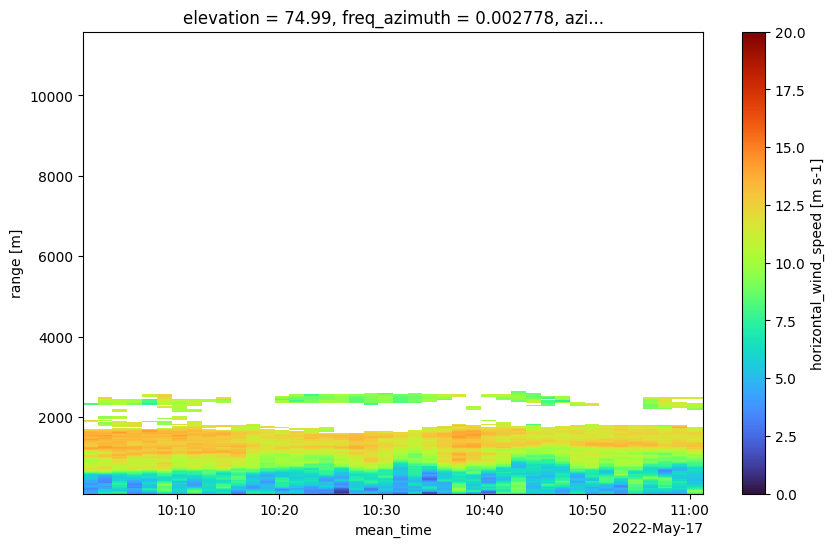

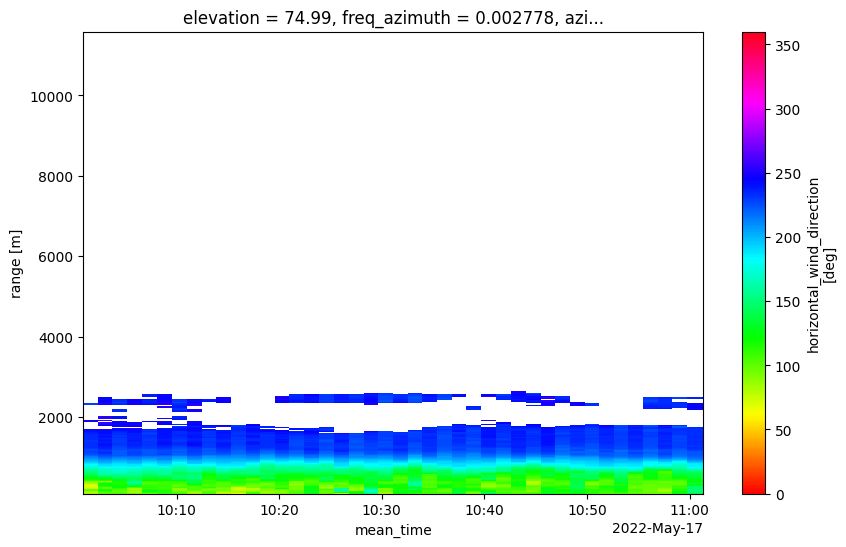

In [9]:
# plotting wind speed and direction
plt.figure(figsize=(10,6))
wind_ds.horizontal_wind_speed.where(wind_ds.nan_percentual<50).plot(y="range", cmap="turbo", vmin=0, vmax=20)
plt.show()

plt.figure(figsize=(10,6))
wind_ds.horizontal_wind_direction.where(wind_ds.nan_percentual<50).plot(y="range", cmap="hsv", vmin=0, vmax=360)
plt.show()

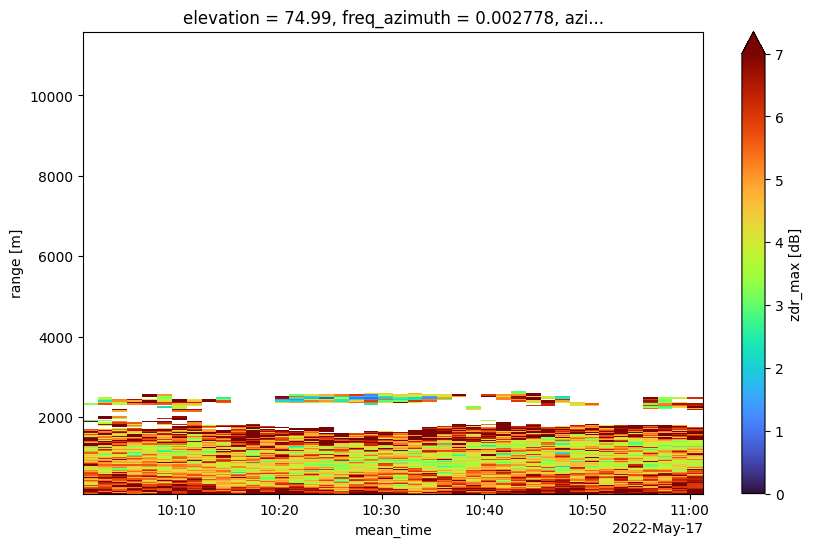

In [10]:
# plotting the maximum ZDR from each scan
plt.figure(figsize=(10,6))
wind_ds.zdr_max.where(wind_ds.nan_percentual<50).plot(y="range", cmap="turbo", vmin=0, vmax=7)
plt.show()

In this last cell, you can save the retrieved wind data as a NetCDF file.
To do it, you just need to uncomment the line below. 

In [11]:
# wind_ds=to_netcdf('retrieved_wind.nc')